In [1]:
import numpyro
import numpyro.distributions as dist
import jax.numpy as jnp
from numpyro.infer import MCMC, NUTS

def complex_mvn_logpdf(z, Gamma):
    """Log-pdf for z ~ CN(0, Gamma), z: (L, K), Gamma: (K, K) Hermitian"""
    L, K = z.shape
    Gamma_inv = jnp.linalg.inv(Gamma)
    sign, logdet = jnp.linalg.slogdet(Gamma)

    # z: (L, K), Gamma_inv: (K, K)
    # Compute quadratic form for each row: zᵢᴴ Γ⁻¹ zᵢ
    quad = jnp.real(jnp.einsum("bi,ij,bj->b", jnp.conj(z), Gamma_inv, z))  # shape (L,)

    return -K * jnp.log(jnp.pi) - logdet - quad

In [2]:
import numpy as np

def simulate_cscn_data(K=3, n_samples=500, seed=0):
    rng = np.random.default_rng(seed)

    # Random low-rank complex A
    r = K
    A = rng.normal(0, 1, size=(K, r)) + 1j * rng.normal(0, 1, size=(K, r))

    # Hermitian PSD
    Gamma = A @ A.conj().T + 0.5 * np.eye(K)

    from scipy.linalg import cholesky
    L = cholesky(Gamma, lower=True)

    # Standard complex normals
    z_std_normal = rng.normal(size=(n_samples, K)) + 1j * rng.normal(size=(n_samples, K))

    # Correct sampling
    z_samples = (L @ z_std_normal.T) / np.sqrt(2)  # shape (K, n_samples)
    z_samples = z_samples.T  # shape (n_samples, K)

    return z_samples, Gamma

z_obs, Gamma_true = simulate_cscn_data(K=5, n_samples=50)


In [3]:
# Empirical covariance
Gamma_emp = np.einsum("li,lj->ij", z_obs, np.conj(z_obs)) / z_obs.shape[0]

# Eigendecomposition (since Gamma_emp is Hermitian)
eigvals, U = np.linalg.eigh(Gamma_emp)  # U ∈ ℂ^{K×K}


In [4]:
eigvals

array([ 0.47964522,  1.41515544,  4.77547234, 11.34877634, 29.2460006 ])

In [5]:
z_obs.shape
empirical = jnp.einsum('lk,lj->lkj', z_obs, z_obs.conj()).mean(0)
eigvals, _ = jnp.linalg.eigh(empirical)


In [6]:
print(eigvals[::-1])
eigvals_true, _ = jnp.linalg.eigh(Gamma_true)
print(eigvals_true[::-1])

[29.245998   11.348776    4.7754736   1.4151523   0.47964406]
[27.415787  10.522855   4.862656   1.4245313  0.6142037]


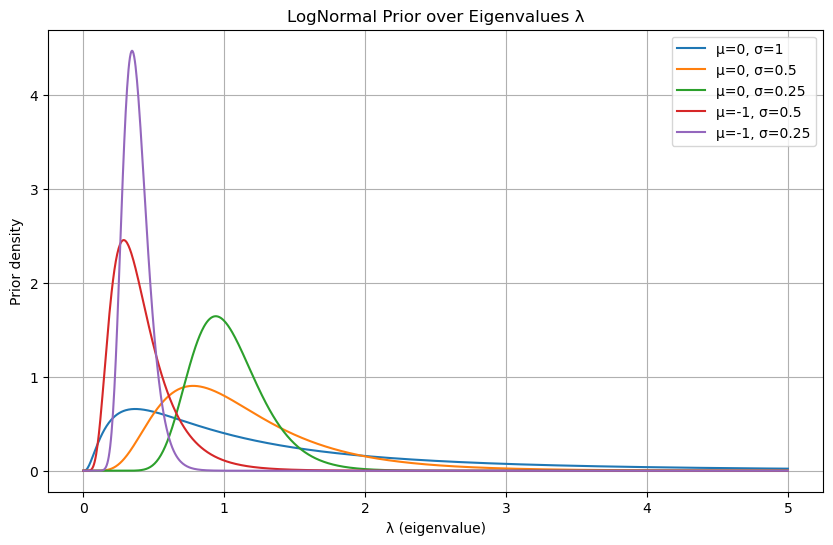

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import lognorm

# Define a grid of lambda values to evaluate the PDF
x = np.linspace(1e-6, 5, 1000)

# Define some (mu, sigma) pairs to try
# params = [(-3, 1), (-5, 1), (-5, 0.5), (-7, 0.5)]
params = [(0, 1), (0, 0.5), (0, 0.25), (-1, 0.5), (-1, 0.25)]

plt.figure(figsize=(10, 6))

for mu, sigma in params:
    # Convert to scipy's parameterization: s = sigma, scale = exp(mu)
    pdf = lognorm.pdf(x, s=sigma, scale=np.exp(mu))
    plt.plot(x, pdf, label=f"μ={mu}, σ={sigma}")

# plt.xscale("log")
# plt.yscale("log")
plt.xlabel("λ (eigenvalue)")
plt.ylabel("Prior density")
plt.title("LogNormal Prior over Eigenvalues λ")
plt.legend()
plt.grid(True, which="both")
plt.show()


In [8]:
jnp.arange(5)[::-1]

Array([4, 3, 2, 1, 0], dtype=int32)

In [9]:
K = 5
-5 + (3*jnp.arange(K)[::-1])

Array([ 7,  4,  1, -2, -5], dtype=int32)

In [11]:
def spectral_shrinkage_model(z_obs, U):
    L, K = z_obs.shape

    # Place shrinkage prior on eigenvalues
    # lambdas = numpyro.sample("lambdas", dist.HalfCauchy(scale=1.0).expand([K]))

    # empirical = jnp.einsum('lk,lj->lkj', z_obs, z_obs.conj()).mean(0)
    # eigvals, _ = jnp.linalg.eigh(empirical)

    # prior_scale = eigvals / eigvals.max()
    # lambdas = numpyro.sample("lambdas", dist.HalfCauchy(scale=prior_scale))

    # Stronger
    # lambdas = numpyro.sample("lambdas", dist.HalfNormal(0.3).expand([K]))

# 
    # log_tau = numpyro.sample("log_tau", dist.Normal(2, 0.8))
    # tau = jnp.exp(log_tau)
    # tau=0.05
    # tau = numpyro.sample("tau", dist.Exponential(30))  # aggressively peaked at 0
    # tau = numpyro.sample("tau", dist.HalfNormal(0.1))  # much tighter



    # Local shrinkage for each λ
    # lambda_std = numpyro.sample("lambda_std", dist.HalfCauchy(tau).expand([K]))
    # lambdas = lambda_std ** 2

    # lambda_std = numpyro.sample("lambda_std", dist.Exponential(15.0).expand([K]))
    # lambdas = lambda_std**2

    # lambdas = numpyro.sample("lambdas", dist.HalfCauchy(1e-15).expand([K]))

    # log_lambda = numpyro.sample("log_lambda", dist.Normal(-5.0, 0.8).expand([K]))
    log_lambda = numpyro.sample("log_lambda", dist.Normal(-4.5 + (2*jnp.arange(K)), 0.1))
    # log_lambda = numpyro.sample("log_lambda", dist.Normal(-5 + jnp.zeros(K), 0.1))

    lambdas = jnp.exp(log_lambda)



    # Construct diagonal matrix
    Lambda = jnp.diag(lambdas)

    # Reconstruct Gamma = U Λ Uᴴ
    U_jax = jnp.array(U)

    # Gamma = U_jax @ Lambda @ jnp.conj(U_jax.T)

    sigma2 = numpyro.sample("sigma2", dist.HalfNormal(1))
    # log_sigma2 = numpyro.sample("log_sigma2", dist.Normal(-1, 0.3))
    # sigma2 = jnp.exp(log_sigma2)

    # sigma2 = numpyro.sample("sigma2", dist.Exponential(30.0))  # even more peaked at 0
    # sigma2 = numpyro.sample("sigma2", dist.HalfCauchy(1.0))


    Gamma = U_jax @ Lambda @ U_jax.conj().T + sigma2 * jnp.eye(K)


    # Likelihood
    logp = complex_mvn_logpdf(z_obs, Gamma)
    numpyro.factor("likelihood", jnp.sum(logp))


In [12]:
from jax.random import PRNGKey

nuts_kernel = NUTS(spectral_shrinkage_model)
mcmc = MCMC(nuts_kernel, num_warmup=500, num_samples=1000)
mcmc.run(PRNGKey(0), z_obs=jnp.array(z_obs), U=U)
posterior = mcmc.get_samples()

/projectnb/stephenlab/jtauber/.conda/envs/pymc_env/lib/python3.13/site-packages/jax/_src/lax/lax.py:5125: ComplexWarning: Casting complex values to real discards the imaginary part
  x_bar = _convert_element_type(x_bar, x.aval.dtype, x.aval.weak_type)
sample: 100%|██████████| 1500/1500 [00:02<00:00, 726.58it/s, 3 steps of size 7.02e-01. acc. prob=0.91] 


In [ ]:
# print(jnp.exp(posterior['log_sigma2']))
# print((posterior['tau']))
# print(jnp.exp((posterior['log_tau'])))
print(jnp.exp((posterior['log_lambda'])))

[[1.3667805e-02 8.5057221e-02 6.2556046e-01 5.6007905e+00 3.2584141e+01]
 [8.7804208e-03 7.3652916e-02 7.5170237e-01 4.6948109e+00 3.2039406e+01]
 [1.1030806e-02 8.1282020e-02 6.7115337e-01 6.4836969e+00 2.8402077e+01]
 ...
 [1.2200718e-02 8.7019093e-02 6.6609967e-01 5.6136165e+00 3.3642761e+01]
 [9.6453149e-03 8.7564446e-02 7.1139014e-01 6.1131320e+00 2.7132982e+01]
 [9.6245296e-03 8.5013047e-02 7.0931244e-01 5.6619849e+00 3.6643066e+01]]


In [14]:
def identity(x):
    return x

def square(x):
    return x**2

# param_name = "lambdas"
# func = identity

param_name = "log_lambda"
func = jnp.exp

# param_name = "lambda_std"
# func = square

Gamma_samples = jnp.einsum(
    "ij,nj,jk->nik", U, jnp.expand_dims(func(posterior[param_name]), -1).squeeze(), jnp.conj(U.T)
)
Gamma_mean = Gamma_samples.mean(axis=0)

In [15]:
Gamma_samples = []

for i in range(posterior["log_lambda"].shape[0]):
    # B_i = posterior["B_real"][i] + 1j * posterior["B_imag"][i]
    D_i = jnp.diag(jnp.exp(posterior["log_lambda"][i]))
    sigma2_i = posterior["sigma2"][i]
    Gamma_i = U @ D_i @ U.conj().T + sigma2_i * jnp.eye(U.shape[0])
    Gamma_samples.append(Gamma_i)

Gamma_samples = jnp.stack(Gamma_samples)  # shape: (n_samples, K, K)
Gamma_mean = jnp.mean(Gamma_samples, axis=0)

In [16]:
func = jnp.exp
param_name = "log_lambda"

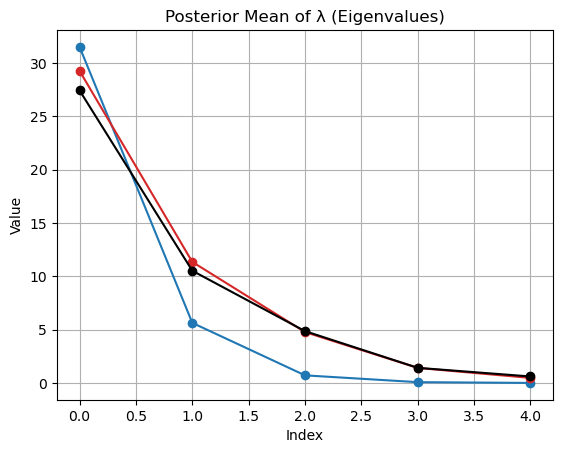

In [17]:
import matplotlib.pyplot as plt
plt.plot(np.sort(func(posterior[param_name]).mean(axis=0))[::-1], "o-")
plt.plot(np.sort(eigvals)[::-1], "o-", color='tab:red')
plt.plot(np.sort(eigvals_true)[::-1], "o-", color='k')
plt.title("Posterior Mean of λ (Eigenvalues)")
plt.ylabel("Value")
plt.xlabel("Index")
# plt.yscale("log")
plt.grid(True)
plt.show()


In [18]:
jnp.round(Gamma_mean, 2)

Array([[ 3.4099998 +0.j        ,  1.15      -0.45999998j,
        -0.39999998+3.08j      , -4.06      +0.63j      ,
        -4.68      -0.55j      ],
       [ 1.15      +0.45999998j,  4.85      -0.j        ,
        -0.05      +4.1j       , -2.9399998 -0.22999999j,
        -1.6999999 +0.21j      ],
       [-0.39999998-3.08j      , -0.05      -4.1j       ,
        10.099999  -0.j        ,  1.67      +7.2j       ,
         2.18      +7.87j      ],
       [-4.06      -0.63j      , -2.9399998 +0.22999999j,
         1.67      -7.2j       , 11.71      -0.j        ,
        10.48      +2.5j       ],
       [-4.68      +0.55j      , -1.6999999 -0.21j      ,
         2.18      -7.87j      , 10.48      -2.5j       ,
        15.839999  +0.j        ]], dtype=complex64)

In [19]:
jnp.round(Gamma_true, 2)

Array([[ 2.9099998 +0.j        ,  1.09      -1.51j      ,
        -0.32      +2.55j      , -3.52      +0.22j      ,
        -4.5299997 -0.88j      ],
       [ 1.09      +1.51j      ,  6.75      +0.j        ,
        -0.09999999+3.8899999j , -1.66      -0.56j      ,
         0.66999996-0.38j      ],
       [-0.32      -2.55j      , -0.09999999-3.8899999j ,
        11.309999  +0.j        , -0.82      +4.7999997j ,
         2.54      +7.1099997j ],
       [-3.52      -0.22j      , -1.66      +0.56j      ,
        -0.82      -4.7999997j ,  9.059999  +0.j        ,
         7.64      +0.91999996j],
       [-4.5299997 +0.88j      ,  0.66999996+0.38j      ,
         2.54      -7.1099997j ,  7.64      -0.91999996j,
        14.809999  +0.j        ]], dtype=complex64)

In [20]:
np.sort(func(posterior[param_name]).mean(axis=0))[::-1]

array([3.1494743e+01, 5.6377687e+00, 7.1963114e-01, 8.2109630e-02,
       1.1081674e-02], dtype=float32)

In [21]:
import matplotlib.pyplot as plt
import numpy as np

def plot_complex_matrix_comparison(true, estimate, title_suffix=""):
    """
    Plot real and imaginary parts of two complex matrices side-by-side.

    Args:
        true (np.ndarray): True complex matrix (K, K)
        estimate (np.ndarray): Estimated complex matrix (K, K)
        title_prefix (str): Optional title prefix for the plots
    """
    fig, axs = plt.subplots(2, 2, figsize=(10, 8))

    im0 = axs[0, 0].imshow(np.real(true), cmap="viridis")
    axs[0, 0].set_title("Re[Γ_true]")
    plt.colorbar(im0, ax=axs[0, 0])

    im1 = axs[0, 1].imshow(np.imag(true), cmap="viridis")
    axs[0, 1].set_title("Im[Γ_true]")
    plt.colorbar(im1, ax=axs[0, 1])

    im2 = axs[1, 0].imshow(np.real(estimate), cmap="viridis")
    axs[1, 0].set_title("Re[Γ_estimated]")
    plt.colorbar(im2, ax=axs[1, 0])

    im3 = axs[1, 1].imshow(np.imag(estimate), cmap="viridis")
    axs[1, 1].set_title("Im[Γ_estimated]")
    plt.colorbar(im3, ax=axs[1, 1])

    plt.suptitle("True vs Estimated Covariance Γ" + title_suffix, fontsize=14)
    plt.tight_layout()
    plt.show()


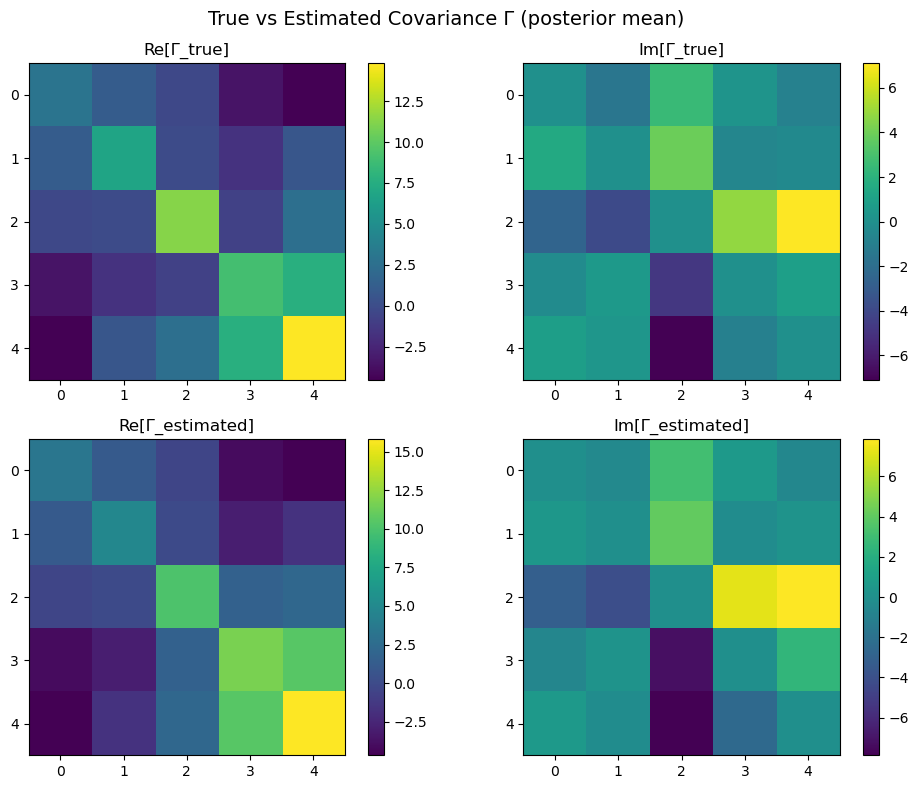

In [22]:
plot_complex_matrix_comparison(Gamma_true, Gamma_samples.mean(0), title_suffix=' (posterior mean)')

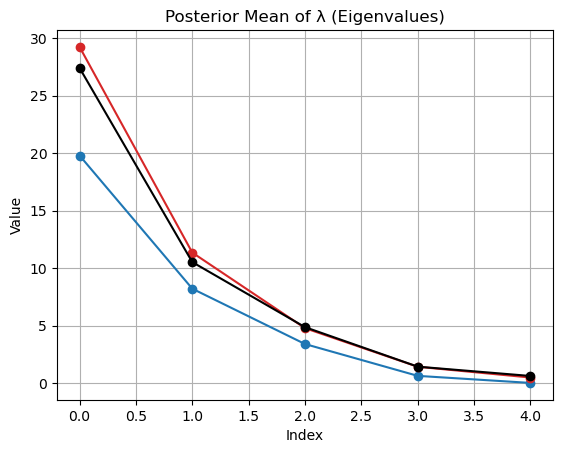

In [382]:
import matplotlib.pyplot as plt
plt.plot(np.sort(func(posterior[param_name]).mean(axis=0))[::-1], "o-")
plt.plot(np.sort(eigvals)[::-1], "o-", color='tab:red')
plt.plot(np.sort(eigvals_true)[::-1], "o-", color='k')
plt.title("Posterior Mean of λ (Eigenvalues)")
plt.ylabel("Value")
plt.xlabel("Index")
# plt.yscale("log")
plt.grid(True)
plt.show()


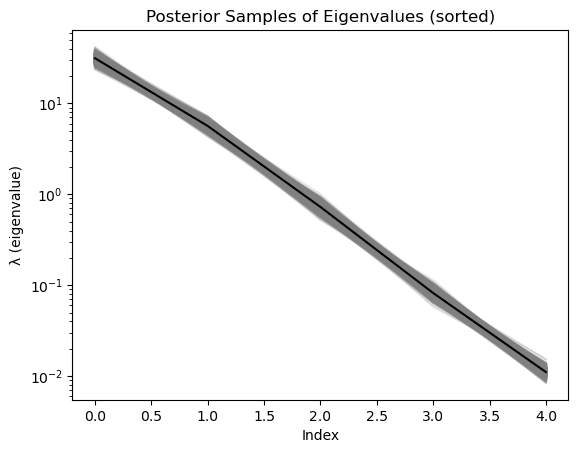

In [27]:
import matplotlib.pyplot as plt

lambdas_samples = func(posterior["log_lambda"])
plt.plot(np.sort(lambdas_samples, axis=1)[:, ::-1].T, alpha=0.2, color="gray")
plt.plot(np.mean(np.sort(lambdas_samples, axis=1)[:, ::-1], axis=0), color="black")
plt.yscale("log")
plt.title("Posterior Samples of Eigenvalues (sorted)")
plt.ylabel("λ (eigenvalue)")
plt.xlabel("Index")
plt.show()

In [29]:
import numpy as np
import matplotlib.pyplot as plt
import jax.numpy as jnp

def plot_posterior_eigenvalues(posterior_eigenvalues):
    """
    Compute and plot posterior distribution of eigenvalues from ARD samples.

    Args:
        posterior: dict of samples from MCMC
        r: number of ARD components
        K: dimensionality of data
    """
    eigenvalues = posterior_eigenvalues

    # Plot
    plt.figure(figsize=(8, 4))
    plt.boxplot(eigenvalues, showfliers=False)
    plt.yscale("log")
    plt.xlabel("Eigenvalue Index")
    plt.ylabel("Eigenvalue")
    plt.title("Posterior Distribution of Eigenvalues (ARD Model)")
    plt.grid(True, which="both")
    plt.tight_layout()
    plt.show()


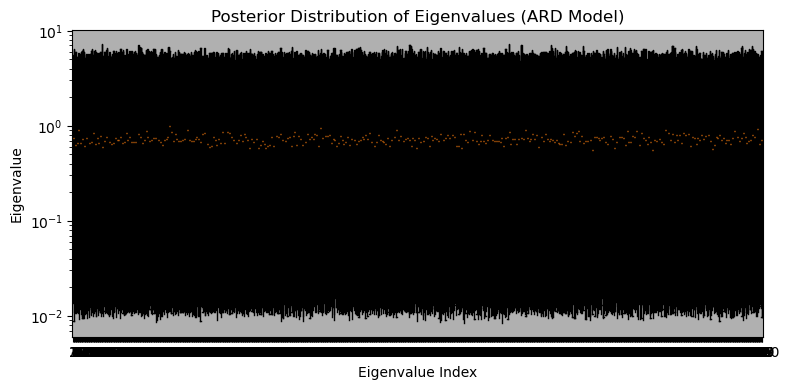

In [30]:
plot_posterior_eigenvalues(func(posterior[param_name]))

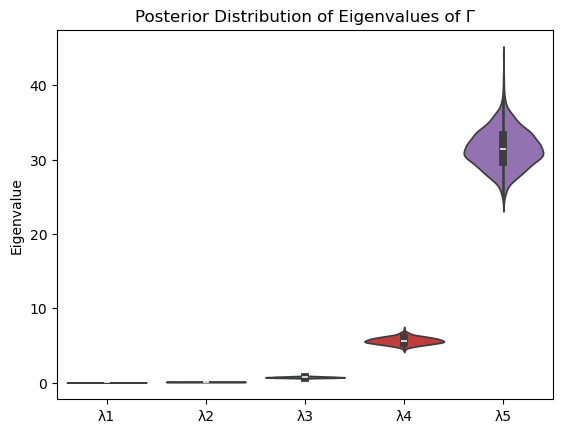

In [23]:
import seaborn as sns
import pandas as pd

eigvals = func(posterior[param_name])
df = pd.DataFrame(np.array(eigvals), columns=[f"λ{i+1}" for i in range(eigvals.shape[1])])
sns.violinplot(data=df)
plt.title("Posterior Distribution of Eigenvalues of Γ")
plt.ylabel("Eigenvalue")
plt.show()
